# Example Complete Workflow: Coal Creek, CO

This workflow provides a complete working example to develop an unstructured mesh for an integrated hydrologic model at the Coal Creek catchment in the Taylor River Basin in Colorado.

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation
* `NLCD` for land cover/transpiration/rooting depths
* `NRCS` soils data for soil types
* `GLYHMPS` geology data for geology types
* `SoilGrids 2017` for depth to bedrock

In [1]:
import os,sys
import numpy as np
import shapely
import logging
import pandas
pandas.options.display.max_columns = None

import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)

/Users/uec/code/seacas/install-master-new/lib/exodus.py:5269: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if exo.modeChar is 'r':


In [2]:
#huc = '140200010204' # Coal Creek, East & Taylor, Upper Co.
hucs = ['140200010101','140200010102','140200010103'] # Headwaters, Upper Taylor River, Middle Taylor River, Taylor River, Upper Co.
crs = workflow.crs.daymet_crs()

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [4]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
workflow.source_list.log_sources(sources)

2021-07-13 10:59:29,220 - root - INFO: Using sources:
2021-07-13 10:59:29,221 - root - INFO: --------------
2021-07-13 10:59:29,222 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-07-13 10:59:29,224 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-07-13 10:59:29,225 - root - INFO: DEM: National Elevation Dataset (NED)
2021-07-13 10:59:29,226 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-07-13 10:59:29,227 - root - INFO: geologic structure: GLHYMPS version 2.0
2021-07-13 10:59:29,228 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-07-13 10:59:29,229 - root - INFO: soil thickness: None
2021-07-13 10:59:29,229 - root - INFO: meteorology: DayMet 1km


In [10]:
# load the hucs
my_hucs = []

for huc in hucs:
    _, watersheds = workflow.get_hucs(sources['HUC'], huc, len(huc), crs)
    assert(len(watersheds) == 1)
    my_hucs.extend(watersheds)
watershed = workflow.split_hucs.SplitHUCs(my_hucs)

# load the huc
#_, watershed = workflow.get_split_form_hucs(sources['HUC'], huc, len(huc), crs)

2021-07-13 11:03:24,066 - root - INFO: 
2021-07-13 11:03:24,068 - root - INFO: Loading level 12 HUCs in 140200010101
2021-07-13 11:03:24,069 - root - INFO: ------------------------------
2021-07-13 11:03:24,073 - root - INFO: Using HUC file "/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2021-07-13 11:03:24,127 - root - INFO: ... found 1 HUCs
2021-07-13 11:03:24,128 - root - INFO:   -- 140200010101
2021-07-13 11:03:24,138 - root - INFO: Converting to out_crs
2021-07-13 11:03:24,165 - root - INFO: Converting to shapely
2021-07-13 11:03:24,167 - root - INFO: 
2021-07-13 11:03:24,168 - root - INFO: Loading level 12 HUCs in 140200010102
2021-07-13 11:03:24,168 - root - INFO: ------------------------------
2021-07-13 11:03:24,171 - root - INFO: Using HUC file "/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2021-07-13 11:03:24,219 - root - INFO: ... found 1 HUCs
2021-07-13 11:03:24,219 - r

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

### Get river network

This will download the river network from the NHD Plus database, and simplify the network, constructing a tree-like data structure.

In [6]:
simplify = 30 # length scale to target average edge

rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs, crs)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, cut_intersections=False,
                                         ignore_small_rivers=2,  prune_by_area_fraction=0.01)


else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)
    


2021-04-30 09:59:27,762 - root - INFO: 
2021-04-30 09:59:27,763 - root - INFO: Loading Hydrography
2021-04-30 09:59:27,763 - root - INFO: ------------------------------
2021-04-30 09:59:27,764 - root - INFO: Loading streams in HUC 140200010204
2021-04-30 09:59:27,764 - root - INFO:          and/or bounds (-589129.0201153527, -364373.59608660906, -578347.0025677136, -357432.40249102714)
2021-04-30 09:59:27,765 - root - INFO:   Using Hydrography file "/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2021-04-30 09:59:27,766 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb' layer 'NHDFlowline' for streams in '(-589129.0201153527, -364373.59608660906, -578347.0025677136, -357432.40249102714)'
/Users/uec/code/watershed_workflow/repos/master/workflow/sources/manager_nhd.py:171: RuntimeWarning: Sequential re

2021-04-30 09:59:57,191 - root - INFO: 
2021-04-30 09:59:57,192 - root - INFO: Simplification Diagnostics
2021-04-30 09:59:57,192 - root - INFO: ------------------------------
2021-04-30 09:59:57,197 - root - INFO:   river min seg length: 45.9158
2021-04-30 09:59:57,198 - root - INFO:   river median seg length: 158.456
2021-04-30 09:59:57,200 - root - INFO:   HUC min seg length: 0
2021-04-30 09:59:57,200 - root - INFO:   HUC median seg length: 0


/Users/uec/code/miniconda/envs/watershed_workflow_20210527/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


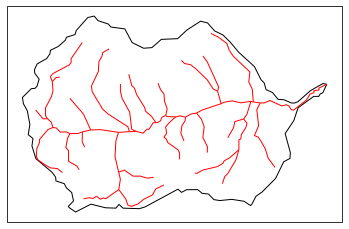

In [7]:
# plot what we have so far -- an image of the HUC and its stream network
fig, ax = workflow.plot.get_ax(crs)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)


### Generate meshes using river network and watershed shape

Triangulation refinement: refine triangles if their area (in m^2) is greater than A(d), where d is the 
distance from the triangle centroid to the nearest stream.  A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and linearly interpolates between the two endpoints.

2021-04-30 09:59:57,411 - root - INFO: 
2021-04-30 09:59:57,412 - root - INFO: Meshing
2021-04-30 09:59:57,412 - root - INFO: ------------------------------
2021-04-30 09:59:57,414 - root - INFO: Triangulating...
2021-04-30 09:59:57,415 - root - INFO:    96 points and 96 facets
2021-04-30 09:59:57,415 - root - INFO:  checking graph consistency
2021-04-30 09:59:57,415 - root - INFO:  tolerance is set to 1
2021-04-30 09:59:57,416 - root - INFO:  building graph data structures
2021-04-30 09:59:57,418 - root - INFO:  triangle.build...
2021-04-30 09:59:59,152 - root - INFO:   ...built: 4362 mesh points and 8505 triangles
2021-04-30 09:59:59,153 - root - INFO: Plotting triangulation diagnostics
2021-04-30 09:59:59,651 - root - INFO:   min area = 1473.574691772461
2021-04-30 09:59:59,652 - root - INFO:   max area = 49392.05255126953


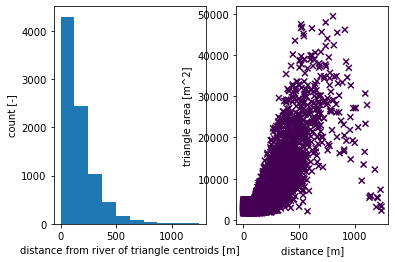

In [8]:
d0 = 100; d1 = 500
A0 = 5000; A1 = 50000 # [100, 310]m

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, distances = workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True,
                                               )

### Map mesh to DEM

Download a DEM from USGS NED and elevate the triangle nodes to the DEM.

In [9]:
# download the needed rasters
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

2021-04-30 09:59:59,864 - root - INFO: 
2021-04-30 09:59:59,865 - root - INFO: Loading Raster
2021-04-30 09:59:59,865 - root - INFO: ------------------------------
2021-04-30 09:59:59,866 - root - INFO: Collecting raster
2021-04-30 09:59:59,963 - root - INFO: Collecting DEMs to tile bounds: [-107.11634327439819, 38.8177028824398, -106.96736783084837, 38.904667886502494]
2021-04-30 09:59:59,964 - root - INFO:   Need:
2021-04-30 09:59:59,965 - root - INFO:     /Users/uec/code/watershed_workflow/data-library/dem/USGS_NED_1as_n39_w108.tif
2021-04-30 09:59:59,965 - root - INFO:     /Users/uec/code/watershed_workflow/data-library/dem/USGS_NED_1as_n39_w107.tif
2021-04-30 09:59:59,966 - root - INFO: source files already exist!
2021-04-30 09:59:59,995 - root - INFO: ... got raster of shape: (314, 537)
2021-04-30 10:00:00,006 - root - INFO: ... got raster bounds: (-107.11634327439819, 38.904667886502494, -106.96717660772657, 38.8174456641992)


In [10]:
# elevate the x,y points onto the DEM to get a z coordinate
mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)

2021-04-30 10:00:00,011 - root - INFO: 
2021-04-30 10:00:00,012 - root - INFO: Elevating Triangulation to DEM
2021-04-30 10:00:00,012 - root - INFO: ------------------------------


### Plot surface meshes

Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

/Users/uec/code/watershed_workflow/repos/master/workflow/plot.py:111: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=window)


[Text(-365000.0, 0, ''),
 Text(-364000.0, 0, ''),
 Text(-363000.0, 0, ''),
 Text(-362000.0, 0, ''),
 Text(-361000.0, 0, ''),
 Text(-360000.0, 0, ''),
 Text(-359000.0, 0, ''),
 Text(-358000.0, 0, ''),
 Text(-357000.0, 0, '')]

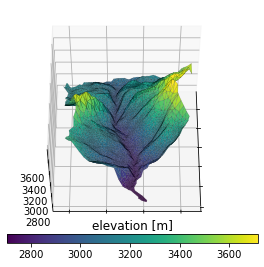

In [11]:
# plot the resulting surface mesh in 3D
fig, ax = workflow.plot.get_ax('3d', window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(55,0)
ax.set_xticklabels(list())
ax.set_yticklabels(list())


Text(0.5, 1.0, 'elevation [m]')

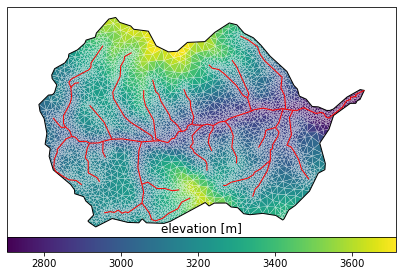

In [12]:
# plot the resulting surface mesh
fig, ax = workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')
cbar.ax.set_title('elevation [m]')


### Construct a 2D mesh

Given the triangle coordinates, we can now construct the 2D mesh object, which stores geometry, topology, and labeled regions.

In [13]:
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

### Hydrologically condition the mesh

Conditions a mesh, in place, by removing artificial pits. 

2021-04-30 10:00:01,563 - root - INFO: max diff = 93.59122185504793


Text(0.5, 1.0, 'conditioned dz')

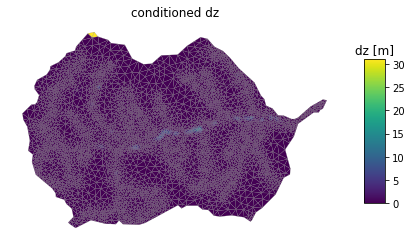

In [14]:
# hydrologically condition the mesh, removing pits
workflow.condition.fill_pits(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
logging.info(f"max diff = {np.abs(diff[:,2]).max()}")

fig, ax = workflow.plot.get_ax(crs)
cbax = fig.add_axes([.95,0.25,0.05,0.5])
mp = workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
cbar.ax.set_title('dz [m]')
ax.axis('off')
ax.set_title('conditioned dz')


## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed forest.

In [15]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2021-04-30 10:00:01,858 - root - INFO: 
2021-04-30 10:00:01,859 - root - INFO: Loading Raster
2021-04-30 10:00:01,859 - root - INFO: ------------------------------
2021-04-30 10:00:01,860 - root - INFO: Collecting raster
2021-04-30 10:00:01,865 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2021-04-30 10:00:01,909 - root - INFO: ... got raster of shape: (245, 374)
2021-04-30 10:00:01,919 - root - INFO: ... got raster bounds:

(-589668.1208500001, -577807.90215, -364720.6557, -357085.3423)

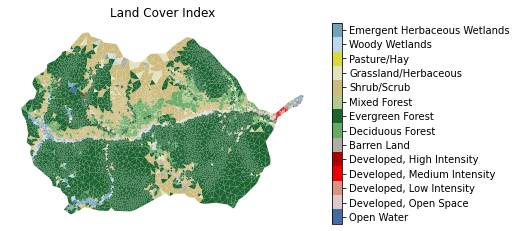

In [16]:
# plot the image
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

fig, ax = workflow.plot.get_ax(crs)
polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)

workflow.colors.colorbar_index(ncolors=len(np.unique(lc)), cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")
ax.axis('off')


## Subsurface properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

Finally, the bottom-most layer is bedrock, where we assume typical properties.

### SSURGO Soil Properties

Note there is missing data here, and some inconsistencies across map boundaries, which makes this data not always ideal.  We use these properties where they are available, and fill with other values as needed.  SSURGO cannot really be used in an automated way for this reason.

In [17]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))
soil_profile, soil_survey, soil_survey_props = workflow.get_shapes(sources['soil structure'], 
                                                                   target_bounds, crs, crs, properties=True)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['mukey'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

2021-04-30 10:00:04,242 - root - INFO: target bounds: (-589129.0201153527, -364373.59608660906, -578347.0025677136, -357432.40249102714)
2021-04-30 10:00:04,243 - root - INFO: 
2021-04-30 10:00:04,244 - root - INFO: Loading shapes
2021-04-30 10:00:04,244 - root - INFO: ------------------------------
2021-04-30 10:00:04,295 - root - INFO: Attempting to download source for target '/Users/uec/code/watershed_workflow/data-library/soil_structure/SSURGO/SSURGO_-107.1094_38.8261_-106.9727_38.9000.shp'
2021-04-30 10:00:04,304 - root - INFO:   Found 135 shapes.
2021-04-30 10:00:04,315 - root - INFO:   and crs: +init=epsg:4326 +type=crs
2021-04-30 10:00:04,327 - root - INFO: found 39 unique MUKEYs.
2021-04-30 10:00:06,063 - root - INFO: Running Rosetta for van Genutchen parameters
2021-04-30 10:00:06,064 - root - INFO:   database: /Users/uec/code/watershed_workflow/repos/master/workflow_tpls/rosetta/sqlite/rosetta.sqlite
2021-04-30 10:00:06,064 - root - INFO:   model type: 3
2021-04-30 10:00:06,

Select only the soils within the watershed

In [18]:
soil_survey_props.set_index('mukey', inplace=True, drop=False)
soil_survey_props = soil_survey_props.loc[np.unique(soil_color), :]

/Users/uec/code/miniconda/envs/watershed_workflow_20210527/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(-589668.1208500001, -577807.90215, -364720.6557, -357085.3423)

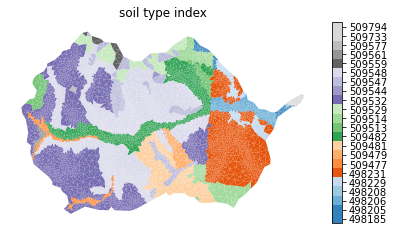

In [19]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )

workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels = labels) 

ax.set_title('soil type index')
ax.axis('off')
# fig.savefig('watershed_soils')

Median soil thickness [-] =  1.52


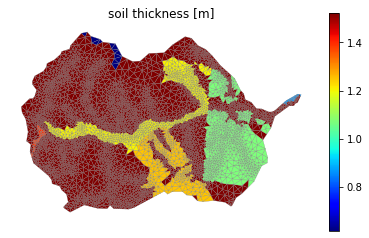

In [20]:
# what does soil thickness look like?
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[mukey,'thickness [cm]']

iprop = iprop / 100
fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet')
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print('Median soil thickness [-] = ', np.nanmedian(iprop))

Median porosity [-] =  0.19334978070175438


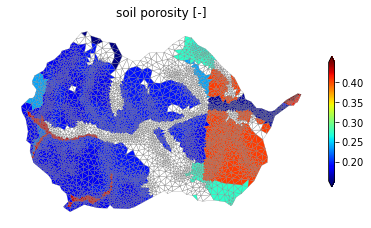

In [21]:
# plot of porosity from SSURGO
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet')
ax.set_title('soil porosity [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
ax.axis('off')

print('Median porosity [-] = ', np.nanmedian(iprop))

Min k [m^2] =  7.0000000000000025e-15


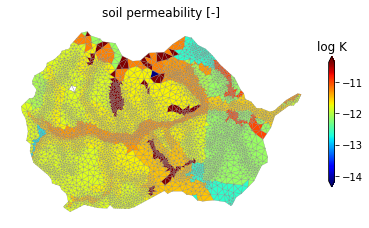

In [22]:
# plot of permeability
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'permeability [m^2]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet')
ax.set_title('soil permeability [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
cb.ax.set_title('log K')
ax.axis('off')

print('Min k [m^2] = ', np.nanmin(iprop))

### GLYHMPS geologic layer

GLYHMPS is complete in that it does not appear to have missing data, but does not have texture properties needed for Water Retention Models.

In [23]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = workflow.get_shapes(sources['geologic structure'], 
                                                      target_bounds, crs, crs, properties=True)

# -- log the bounds targeted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_raster, geo_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, geo_survey,
                                              geo_ids, crs)

# -- resample the raster to the triangles
geo_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geo_color_raster, geo_color_profile)


2021-04-30 10:00:09,515 - root - INFO: target bounds: (-589129.0201153527, -364373.59608660906, -578347.0025677136, -357432.40249102714)
2021-04-30 10:00:09,515 - root - INFO: 
2021-04-30 10:00:09,516 - root - INFO: Loading shapes
2021-04-30 10:00:09,517 - root - INFO: ------------------------------
2021-04-30 10:00:09,517 - root - INFO: Getting shapes of GLHYMPS on bounds: (-589129.0201153527, -364373.59608660906, -578347.0025677136, -357432.40249102714)
2021-04-30 10:00:09,517 - root - INFO:   from file: /Users/uec/code/watershed_workflow/data-library/soil_structure/GLHYMPS/GLHYMPS.shp
2021-04-30 10:00:09,622 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
/Users/uec/code/watershed_workflow/repos/master/workflow/sources/manager_shape.py:76: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shps = [s for (i,s) in fid.items(bbox=bounds)]
2021-04-30 10:00:15,084 - root - INFO: ... found 19 shapes
2021-04

In [24]:
# select the properties that appear in the mesh
geo_survey_props.set_index('id', inplace=True, drop=False)
geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]

(-589668.1208500001, -577807.90215, -364720.6557, -357085.3423)

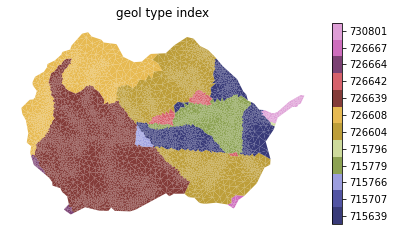

In [25]:
# plot the geologic formation id
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color, cmap='tab20b')

fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color, 
                        cmap=cmap, norm=norm)

workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels=labels) 

ax.set_title('geol type index')
ax.axis('off')

(-589668.1208500001, -577807.90215, -364720.6557, -357085.3423)

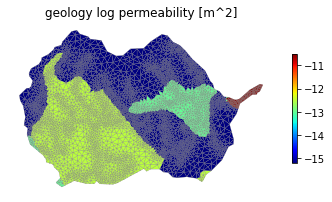

In [26]:
# plot permeability of the underlying geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'permeability [m^2]']
    
fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet')
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology log permeability [m^2]')
ax.axis('off')


(-589668.1208500001, -577807.90215, -364720.6557, -357085.3423)

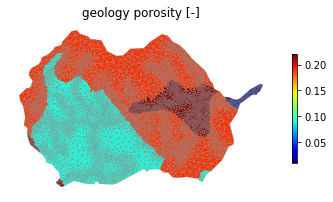

In [27]:
# plot porosity of the geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'porosity [-]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet')
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology porosity [-]')
ax.axis('off')


## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [28]:
DTB_source = workflow.source_list.structure_sources['SoilGrids2017']
DTB_profile, DTB_raster = workflow.get_raster_on_shape(DTB_source, watershed.exterior(), crs, 
                                                       nodata=-99999, variable='BDTICM')

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)
DTB = np.where(DTB >= 0, DTB, np.nan)

2021-04-30 10:00:17,867 - root - INFO: 
2021-04-30 10:00:17,867 - root - INFO: Loading Raster
2021-04-30 10:00:17,868 - root - INFO: ------------------------------
2021-04-30 10:00:17,869 - root - INFO: Collecting raster
2021-04-30 10:00:17,873 - root - INFO: CRS: EPSG:4326
2021-04-30 10:00:17,926 - root - INFO: ... got raster of shape: (33, 63)
2021-04-30 10:00:17,936 - root - INFO: ... got raster bounds: (-107.10833619599228, 38.895835029995425, -106.97708621699222, 38.82708504099539)


Text(0.5, 1.0, 'DTB [m]')

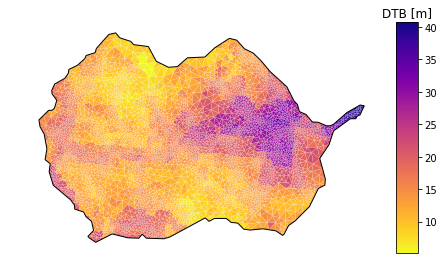

In [29]:
# plot the resulting surface mesh
fig, ax = workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

ax.set_aspect('equal', 'datalim')
ax.axis('off')

cbar.ax.set_title('DTB [m]')


## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs. 999 is reserved for bedrock.
* 1000-9999 : soil layer material IDs




In [31]:
# map SSURGO mukey to ATS_ID
soil_survey_props['ats_id'] = range(1000, 1000+len(soil_survey_props))
soil_survey_props.set_index('ats_id', inplace=True)

# map GLHYMPS id to ATS_ID
geo_survey_props['ats_id'] = range(100, 100+len(geo_survey_props))
geo_survey_props.set_index('ats_id', inplace=True)

# merge the properties databases
subsurface_props = pandas.concat([geo_survey_props,soil_survey_props])

# save the properties to disk for use in generating input file
subsurface_props.to_csv('watershed_subsurface_properties.csv')


Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [33]:
total_thickness = np.ceil(DTB.max())
logging.info(f'total thickness: {total_thickness} m')

2021-04-30 10:05:45,092 - root - INFO: total thickness: 41.0 m


In [34]:
# Generate a dz structure for the top 2m of soil -- it appears from above that the soil thickness is uniformly 2m
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

[0.0500016  0.05030145 0.06625834 0.1110568  0.22600204 0.49640501
 0.49997989 0.49999487]
2.0


In [35]:
# this looks like it would work out:
dzs = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs))

2.0


In [36]:
# a 2m soil thickness and a 17m depth to bedrock suggests a geologic layer of 15 - 1m cells

In [37]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
for dz in dzs:
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    
# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
dz = 2.0
geo_ncells = int(np.ceil((total_thickness- sum(dzs))/dz))
for i in range(geo_ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(geo_color)

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2021-04-30 10:06:48,869 - root - INFO: Cell summary:
2021-04-30 10:06:48,870 - root - INFO: ------------------------------------------------------------
2021-04-30 10:06:48,871 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2021-04-30 10:06:48,872 - root - INFO: ------------------------------------------------------------
2021-04-30 10:06:48,873 - root - INFO:  00 	| 00 	| 509794 	|   0.050000 	|   0.000000
2021-04-30 10:06:48,874 - root - INFO:  01 	| 01 	| 509794 	|   0.050000 	|   0.050000
2021-04-30 10:06:48,876 - root - INFO:  02 	| 02 	| 509794 	|   0.050000 	|   0.100000
2021-04-30 10:06:48,877 - root - INFO:  03 	| 03 	| 509794 	|   0.120000 	|   0.150000
2021-04-30 10:06:48,878 - root - INFO:  04 	| 04 	| 509794 	|   0.230000 	|   0.270000
2021-04-30 10:06:48,878 - root - INFO:  05 	| 05 	| 509794 	|   0.500000 	|   0.500000
2021-04-30 10:06:48,879 - root - INFO:  06 	| 06 	| 509794 	|   0.500000 	|   1.000000
2021-04-30 10:06:48,879 - root - INFO:  07 	| 07 	| 509794 	|   0

Finally, we add the bedrock material.

In [38]:
# get depth of each layer
z_elev = np.cumsum(np.array([0] + dzs + [dz]*geo_ncells))
z_center = z_elev[:-1] + (z_elev[1:] - z_elev[:-1])/2

In [41]:
mat_ids = np.stack(layer_mat_ids)

for icol in np.arange(mat_ids.shape[1])[:]:
    idtb = DTB[icol]
    idx = z_center > idtb
    
    # assign 999 to bedrock
    mat_ids[idx, icol] = 999

In [42]:
layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

In [43]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [44]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [45]:
# save to disk
try:
    os.remove('CoalCreek.exo')
except FileNotFoundError:
    pass
m3.write_exodus('CoalCreek.exo')


You are using exodus.py v 1.20.0 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: CoalCreek.exo
Closing exodus file: CoalCreek.exo
